<a href="https://colab.research.google.com/github/ryzwann/tugas-3-multilable_classification/blob/main/Tugas3_Multilabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import keras
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
import os
os.environ["KAGGLE_USERNAME"] = "muhammadrizwandarwis"
os.environ["KAGGLE_KEY"] = "9e4a9ddf0509d6a22630d1228136ed67"

In [10]:
!kaggle datasets download -d datasetmultilabel-Muhammad-Rizwan-202255202085

Dataset URL: https://www.kaggle.com/datasets/muhammadrizwandarwis/datasetmultilabel-Muhammad-Rizwan-202255202085
License(s): other


In [15]:
# prompt: unzip file movie-classifier.zip

!!unzip -o datasetmultilabel-Muhammad-Rizwan-202255202085.zip -d dataset


['Archive:  datasetmultilabel-Muhammad-Rizwan-202255202085.zip',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar001.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar002.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar003.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar004.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar005.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar006.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar007.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar008.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar009.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar010.jpg

In [24]:
# Baca file CSV dengan delimiter yang sesuai
# df = pd.read_csv('/content/traindataset_Muhammad_Rizwan_Darwis_202255202085.xlsx', delimiter=';')
df = pd.read_excel('/content/traindataset_Muhammad_Rizwan_Darwis_202255202085.xlsx') # Use pd.read_excel for .xlsx files

# Tampilkan 5 baris pertama dengan format tabel
display(df.head())  # Gunakan display() jika di Jupyter/Colab

,Id,Object,Buku,Sepatu,Gelas,Sendok Nasi
0,Gambar001,"['Buku, 'Sepatu']",1,1,0,0
1,Gambar002,"['Buku', 'Sepatu', 'Gelas', 'Sendok Nasi']",1,1,1,1
2,Gambar003,"['Buku', 'Sepatu', 'Gelas', 'Sendok Nasi']",1,1,1,1
3,Gambar004,"['Buku', 'Sepatu', 'Gelas']",1,1,1,0
4,Gambar005,"['Buku', 'Sepatu',]",1,1,0,0


In [25]:
SIZE = 224
X_dataset = []
#Define image_directory before it's used in the loop
image_directory = '/content/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085' # Change to extracted image directory
for i in tqdm(range(df.shape[0])):
    # Added '/' as a separator between image_directory and filename
    img = image.load_img(image_directory + '/' + df['Id'][i]+'.jpg', target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

X = np.array(X_dataset)

100%|██████████| 300/300 [00:22<00:00, 13.49it/s]


In [26]:
#
print(df['Id'][250])

Gambar251


In [27]:
print(df['Object'][250])  #Tagged as multiple Object.

['Buku, 'Sepatu']


In [28]:
#Id and Object are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['Id', 'Object'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [29]:
# Ganti SIZE dengan ukuran input gambar (contoh: 224)
SIZE = 224

# Load MobileNetV2 tanpa top classifier
base_model = MobileNetV2(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Bekukan weight pre-trained untuk transfer learning awal

# Instead of creating a new model, use the base_model as the starting point
# and add layers on top of it using the Functional API.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='sigmoid')(x)  # Untuk multilabel classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
from tensorflow.keras.metrics import AUC

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

In [31]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - auc: 0.7266 - loss: 0.6508 - val_auc: 0.9075 - val_loss: 0.3670
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - auc: 0.8643 - loss: 0.4668 - val_auc: 0.9356 - val_loss: 0.2802
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8591 - loss: 0.4258 - val_auc: 0.9501 - val_loss: 0.2740
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.9332 - loss: 0.3122 - val_auc: 0.9549 - val_loss: 0.2457
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.9412 - loss: 0.2730 - val_auc: 0.9587 - val_loss: 0.2209
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.9507 - loss: 0.2692 - val_auc: 0.9663 - val_loss: 0.2010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.9484 - loss: 0.2567 - val_auc: 0.9702 - val_loss: 0.1939
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.9566 - loss: 0.2386 - val_auc: 0.9757 - val_loss: 0.1891
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - auc: 0.9677 - loss: 0.2199 - v

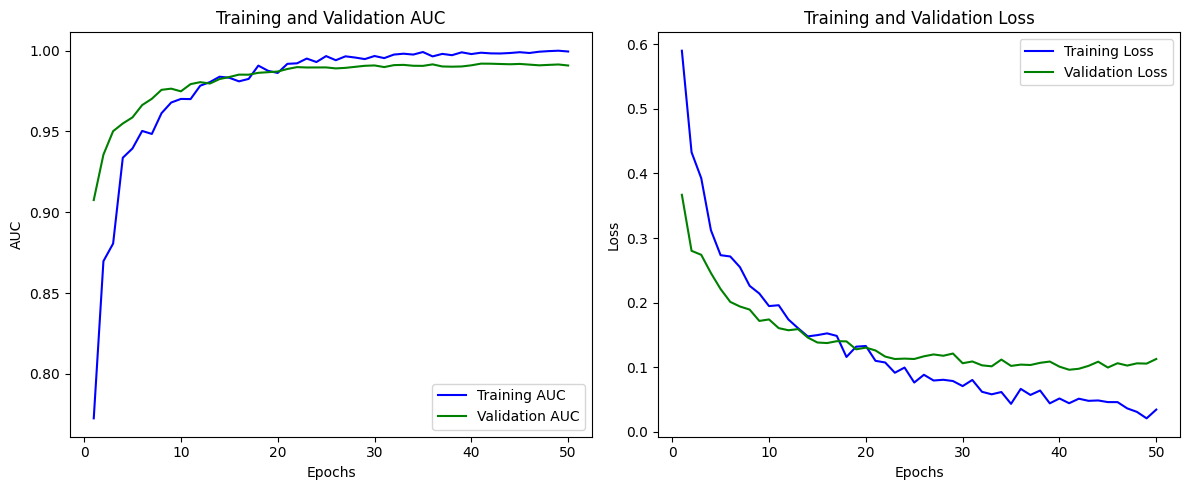

In [32]:
import matplotlib.pyplot as plt

# Ambil nilai AUC dan Loss dari riwayat training
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(auc) + 1)

# Plot AUC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


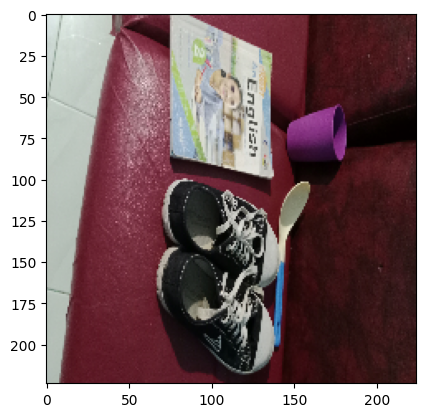

In [44]:
#Gambar yang diprediksi
img = image.load_img('/content/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar165.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

In [45]:
#Print classes and corresponding probabilities
for i in range(4):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

Sepatu (1.0)
Gelas (1.0)
Buku (1.0)
Sendok Nasi (0.99)


In [46]:
###################################################

loss, auc = model.evaluate(X_test, y_test)
print("AUC = ", (auc * 100.0), "%")

###################################################

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.9909 - loss: 0.1174
AUC =  99.07482266426086 %


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
              precision    recall  f1-score   support

        Buku       1.00      1.00      1.00        90
      Sepatu       1.00      1.00      1.00        90
       Gelas       0.99      1.00      0.99        67
 Sendok Nasi       0.76      0.83      0.79        35

   micro avg       0.97      0.98      0.97       282
   macro avg       0.94      0.96      0.95       282
weighted avg       0.97      0.98      0.97       282
 samples avg       0.97      0.98      0.97       282



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


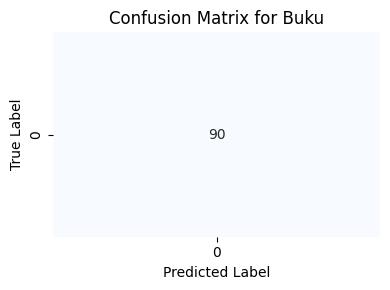

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


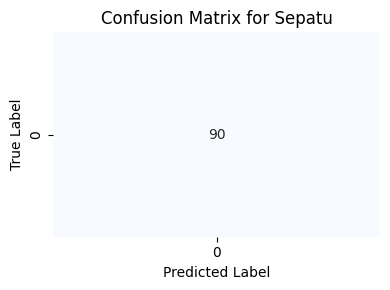

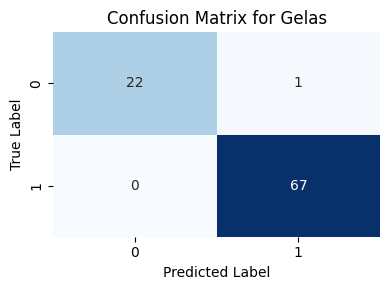

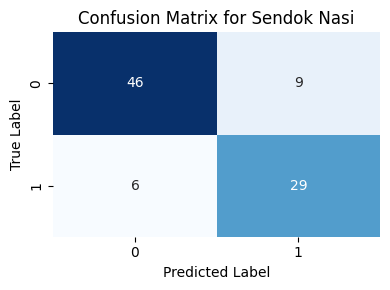

In [47]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Visualisasi confusion matrix untuk setiap label
for i in range(len(classes)):
    cm = confusion_matrix(y_test[:, i], y_pred_classes[:, i])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {classes[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
